# Microsam training on negative data

## Can we learn to 'not' predict certain shapes? 

This notebook shows how to use Segment Anything for Microscopy to fine-tune a Segment Anything Model (SAM) on the disk-like and rod-like shapes shown in this [image.sc question](https://forum.image.sc/t/micro-sam-training-on-negative-data/111248) 

The goal is to train two models, one that only detects disk-like objects and returns nothing for rod-like, and one that only detects rod-like objects and returns nothing for disk-like.  The training set is a combination of rod-like and disk-like objects with the masks for the 'negative' class empty. 

(this notebook is a derivative of the [micro-sam fine tuning](https://github.com/computational-cell-analytics/micro-sam/blob/master/notebooks/sam_finetuning.ipynb) example)

We modify based on latest updates to Microsam as described by Constantin Pape [here](https://forum.image.sc/t/micro-sam-training-on-negative-data/111248/10)

## Running this notebook

As of April 22nd 2025 you need to run this notebook with the development branch of Microsam as described [here](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#from-source)
(it's quite possible, that if you are looking at this example sometime farther away from April 2025 the changes will have been migrated to the main ```microsam``` code base)

```
git clone https://github.com/computational-cell-analytics/micro-sam
git fetch
git checkout -b dev
cd micro-sam
conda env create -f environment.yaml
conda activate sam
pip install -e .
```

Then you need to change a line in [training.py](https://github.com/computational-cell-analytics/micro-sam/blob/dev/micro_sam/training/training.py#L495)

Around line 495 in the ```train_instance_segmentation``` function change 

```
loss = torch_em.loss.DiceBasedDistanceLoss(mask_distances_in_bg=True)
```

to

```
loss = torch_em.loss.DistanceLoss(mask_distances_in_bg=True, foreground_loss =  nn.MSELoss(reduction="mean"))
```

Because [Dice Loss](https://chatgpt.com/c/6808d169-4130-800e-9b60-8ba8c5687ba4) depending on how it is implemented may not work for empty masks.



## Check pytorch and GPU

In [17]:
import torch
import os
print(torch.cuda.is_available())  # Returns True if a GPU is available

print(torch.cuda.current_device())  # Returns the current GPU device index
print(torch.cuda.device_count())    # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the first GPU (if available)

True
0
1
NVIDIA GeForce RTX 3090


### Importing the libraries

In [18]:
import warnings
import os
warnings.filterwarnings("ignore")

from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components

import torch

from torch_em.util.debug import check_loader
from torch_em.data import MinInstanceSampler

import micro_sam.training as sam_training
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

## Set paths

Below we set paths to our training data and the location we wish to put the trained model

In [3]:
parent_path = r'D:\images\tnia-python-images\imagesc\2025_04_12_disk_like'
train_path = os.path.join(parent_path, 'patches')
model_path = os.path.join(parent_path, 'models')

segmentation_dir = train_path + '/ground truth0'
image_dir = train_path + '/input0'

## convert to 8 bit

For micro-sam inputs must be in 8 bit.  My training data generator outputs the images as normalized float bit so I convert to 8-bit in the cell below. 

(If you are using training data already in 8 bit format don't worry about his cell, but make sure you explicitly point ```image_dir_8bit``` to your training data)

In [20]:
image_dir_8bit = train_path + '/input0_255'

# if no 8-bit images yet make them
if not os.path.exists(image_dir_8bit):
    os.makedirs(image_dir_8bit)

    image_paths = sorted(glob(os.path.join(image_dir, "*")))

    for image_path in image_paths:
        image = imageio.imread(image_path)
        image = (image * 255).astype('uint8')
        imageio.imwrite(image_path.replace(image_dir, image_dir_8bit), image)


### Let's create the dataloaders

Our task is to segment HeLa cells on a flat glass in DIC microscopic images. The dataset comes from https://celltrackingchallenge.net/2d-datasets/, and the dataloader has been implemented in [torch-em](https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/ctc.py).

#### First, let's visualize how our samples look.

image size is (256, 256)


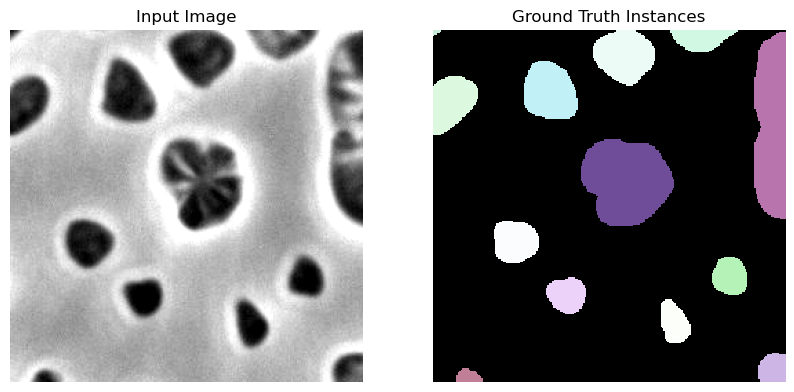

In [21]:
def random_label_cmap(n=2**16, h = (0,1), l = (.4,1), s =(.2,.8)):
    """
    Create a random colormap for labels
    
    Args:
        n (int, optional): number of labels. Defaults to 2**16.
        h (tuple, optional): hue range. Defaults to (0,1).
        l (tuple, optional): lightness range. Defaults to (.4,1).
        s (tuple, optional): saturation range. Defaults to (.2,.8).
        
        Returns:
        matplotlib.colors.ListedColormap: colormap for labels
    """
    import matplotlib
    import colorsys
    # cols = np.random.rand(n,3)
    # cols = np.random.uniform(0.1,1.0,(n,3))
    h,l,s = np.random.uniform(*h,n), np.random.uniform(*l,n), np.random.uniform(*s,n)
    cols = np.stack([colorsys.hls_to_rgb(_h,_l,_s) for _h,_l,_s in zip(h,l,s)],axis=0)
    cols[0] = 0
    return matplotlib.colors.ListedColormap(cols)

image_dir = image_dir_8bit
image_paths = sorted(glob(os.path.join(image_dir, "*")))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    print('image size is', image.shape)
    segmentation = imageio.imread(segmentation_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    segmentation = connected_components(segmentation)
    ax[1].imshow(segmentation, cmap=random_label_cmap(), interpolation="nearest")
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")

    plt.show()
    plt.close()

    break  # comment this out in case you want to visualize all the images

#### Next, let's create the dataloaders

In [7]:
# 'micro_sam.training.default_sam_loader' is a convenience function to build a pytorch dataloader from image data and labels for training segmentation models.
# This is wrapped around the 'torch_em.default_segmentation_loader'.
# It supports image data in various formats.
# Here, we load image data and labels from the two folders with tif images that were downloaded by the example data functionality,
# by specifying `raw_key` and `label_key` as `*.tif`.
# This means all images in the respective folders that end with .tif will be loaded.
# The function supports many other file formats. For example, if you have tif stacks with multiple slices instead of multiple tif images in a folder,
# then you can pass 'raw_key=label_key=None'.
# For more information, here is the documentation: https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/README.md
# And here is a tutorial on creating dataloaders using 'torch-em': https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

# Load images from multiple files in folder via pattern (here: all tif files)
raw_key, label_key = "*.tif", "*.tif"

# Alternative: if you have tif stacks you can just set 'raw_key' and 'label_key' to None
# raw_key, label_key= None, None

# The 'roi' argument can be used to subselect parts of the data.
# Here, we use it to select the first 70 images (frames) for the train split and the other frames for the val split.

train_roi = np.s_[:, :, :]
val_roi = np.s_[80:120, :, :]

## Create datasets

We create datasets mostly following the example ```microsam``` training code. 

We comment a few un-needed parts out.  For example we don't to use the ```MinInstanceSampler```, as in this case we want to use the images with empty masks so the model learns to ignore negative data. 

In [22]:
# The script below returns the train or val data loader for finetuning Segment Anything Model (SAM).
# The data loader must be a torch data loader that returns `x, y` tensors, where `x` is the image data and `y` are the labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# Important: the ID 0 is reseved for background, and the IDs must be consecutive

# Here, we use `micro_sam.training.default_sam_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

batch_size = 1  # the training batch size
patch_shape = (256, 256)  # the size of patches for training

# NOTE: For this example we only want to train the instance segmentation decoder
train_instance_segmentation_only = True

# NOTE: The dataloader internally takes care of adding label transforms: i.e. used to convert the ground-truth
# labels to the desired instances for finetuning Segment Anythhing, or, to learn the foreground and distances
# to the object centers and object boundaries for automatic segmentation.

# The sampler below makes sure that the chosen inputs have atleast one foreground instance, and filters out small objects.
# BUT: this is not needed for the example data as WE WANT to train all images even ones with no instances.
# keep a look out for below line in other example code, as IF training on images with no instances is desired, then this line should be commented out.
#sampler = MinInstanceSampler(min_num_instances=0,min_size=0)  # NOTE: The choice of 'min_size' value is paired with the same value in 'min_size' filter in 'label_transform'.

train_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=True,
    train_instance_segmentation_only = True,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_train=True,
    rois=train_roi,
    #shuffle=True,
    #raw_transform=sam_training.identity,
    #sampler=sampler,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=True,
    train_instance_segmentation_only = True,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_train=False,
    rois=val_roi,
    #shuffle=True,
    #raw_transform=sam_training.identity,
    #sampler=sampler,
)

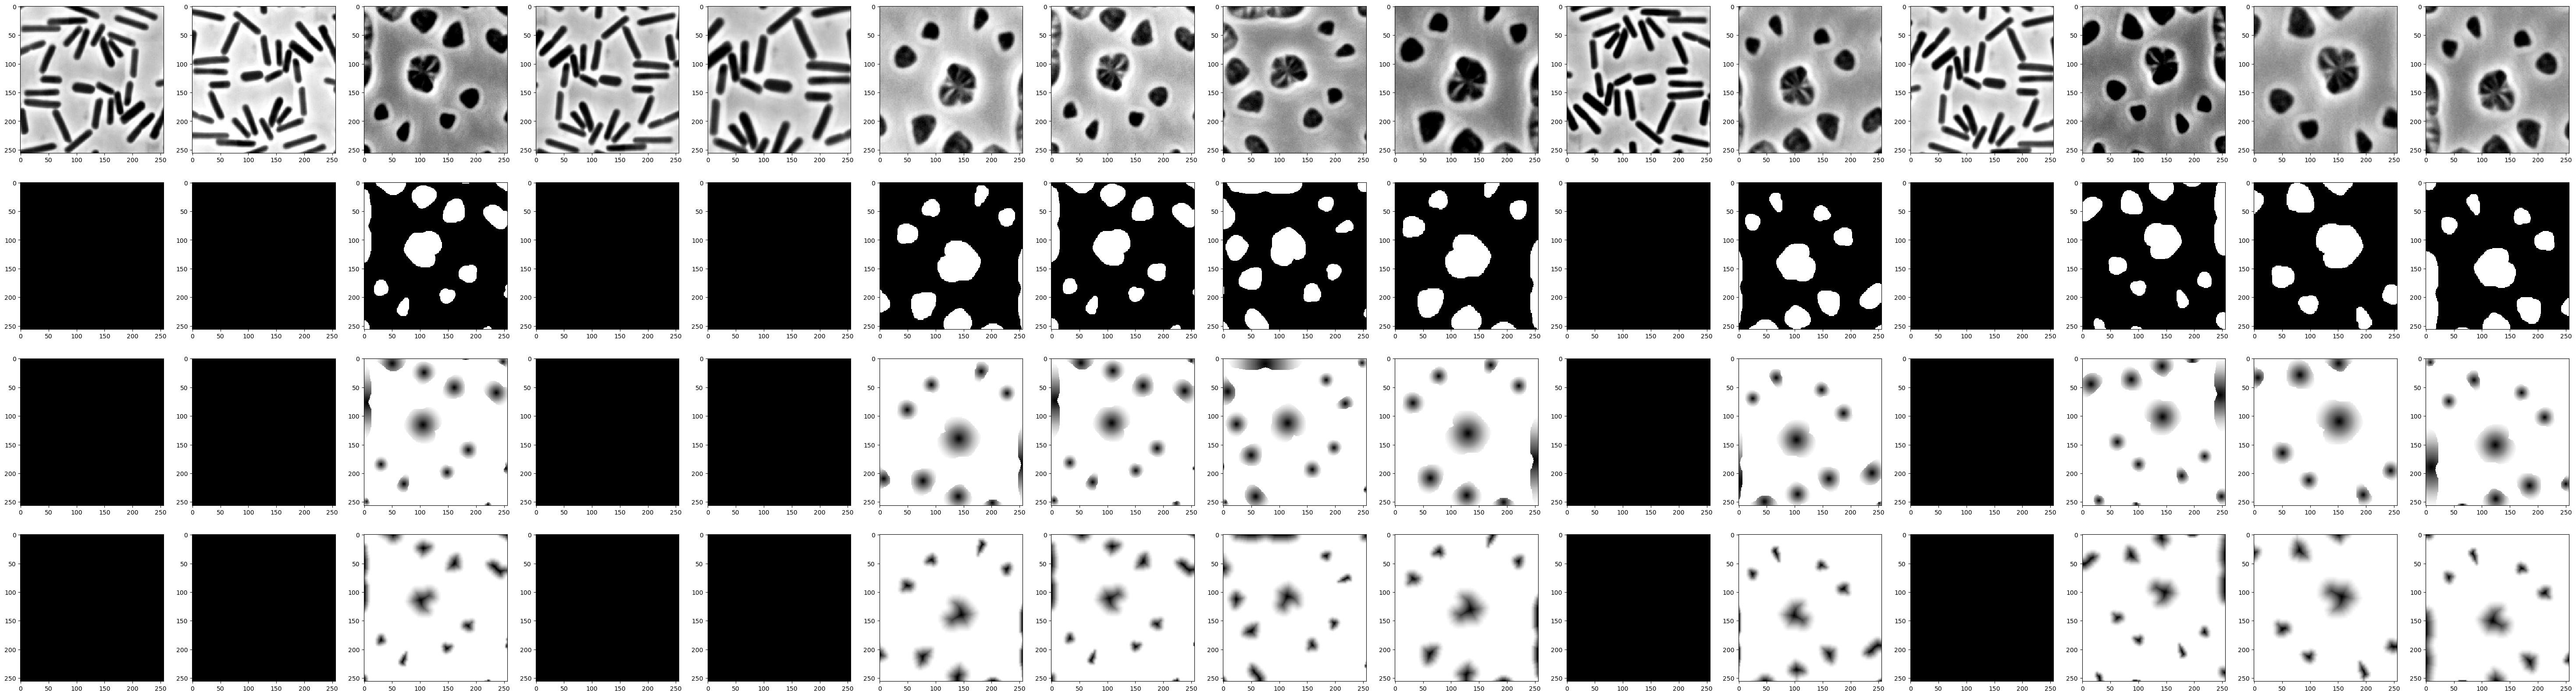

In [23]:
# Let's check how our samples look from the dataloader

# we should see
# Some example of the disk like objects and their instance segmentation masks
# Some examples of the rod like objects with empty instance segmentation masks
check_loader(train_loader, 15, plt=True)

### Run the actual model finetuning

**NOTE 1**: The user needs to decide whether to finetune the Segment Anything model, or the `µsam`'s "finetuned microscopy models" for their dataset. Here, we finetune on the Segment Anything model for simplicity. For example, if you choose to finetune the model from the light microscopy generalist models, you need to update the `model_type` to `vit_b_lm` and it takes care of initializing the model with the desired weights)

**NOTE 2** Increase number of epochs for training in real scenarios.  

In [ ]:
# All hyperparameters for training.
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 3  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_b"

model_name = os.path.join(model_path, 'microsam_detect_empty_rods')

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "empty_rod_checkpoints"


In [ ]:
# Run training 
sam_training.train_instance_segmentation(
    name=checkpoint_name,
    save_root=model_name, #os.path.join(root_dir, "models"),
    model_type=model_type,
    #checkpoint_path = checkpoint_previous_best_path,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=2,#n_epochs,#n_epochs,
    #lr = 1e-3,
    device=device,
)

Start fitting for 400 iterations /  2 epochs
with 200 iterations per epoch
Training with mixed precision


Epoch 2: average [s/it]: 0.353859, current metric: 0.020836, best metric: 0.020836: 100%|█████████▉| 399/400 [02:34<00:00,  2.58it/s]

Finished training after 2 epochs / 400 iterations.
The best epoch is number 1.
Training took 155.82363080978394 seconds (= 00:02:36 hours)


## Export model

We need to export the model to the same format of the other microsam models

In [12]:
#print(model_name)
#print(checkpoint_name)

#current_best_checkpoint = r'D:\images\tnia-python-images\imagesc\2025_04_12_disk_like\models\microsam_detect_0\checkpoints\microsam_detect_0_ceckpoints\best.pt'
current_best_checkpoint = os.path.join(model_name, "checkpoints", checkpoint_name, "best.pt")
print(current_best_checkpoint)
exported_model_name = os.path.join(model_path, 'microsam_mse_loss', "exported.pt")

# if does not exist, create the directory
if not os.path.exists(os.path.dirname(exported_model_name)):
    os.makedirs(os.path.dirname(exported_model_name))

sam_training.export_instance_segmentation_model(current_best_checkpoint, exported_model_name, model_type)

D:\images\tnia-python-images\imagesc\2025_04_12_disk_like\models\microsam_detect_empty_rods\checkpoints\microsam_detect_0_ceckpoints\best.pt


### Let's run the automatic instance segmentation (AIS)

In [13]:
def run_automatic_instance_segmentation(image, checkpoint_path, model_type="vit_b_lm", device=None, tile_shape = None, halo = None):
    """Automatic Instance Segmentation (AIS) by training an additional instance decoder in SAM.

    NOTE: AIS is supported only for `µsam` models.

    Args:
        image: The input image.
        checkpoint_path: The path to stored checkpoints.
        model_type: The choice of the `µsam` model.
        device: The device to run the model inference.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=model_type, # choice of the Segment Anything model
        checkpoint=checkpoint_path,  # overwrite to pass your own finetuned model.
        device=device,  # the device to run the model inference.
        is_tiled = (tile_shape is not None),  # whether the model is tiled or not.
    )

    # Step 2: Get the instance segmentation for the given image.
    prediction = automatic_instance_segmentation(
        predictor=predictor,  # the predictor for the Segment Anything model.
        segmenter=segmenter,  # the segmenter class responsible for generating predictions.
        input_path=image,
        #ndim=2,
        tile_shape=tile_shape,
        halo=halo,
        foreground_threshold = 0.84
    )

    return prediction

**NOTE** When calling ```run_automatic_instance_segmentation``` we pass the ```exported_model_name```

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


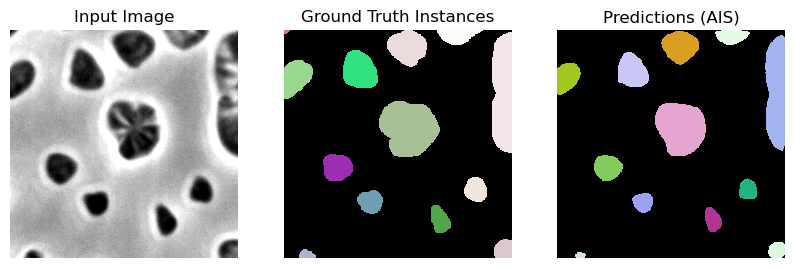

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


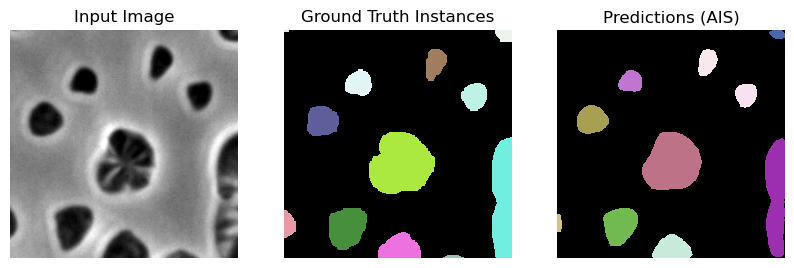

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


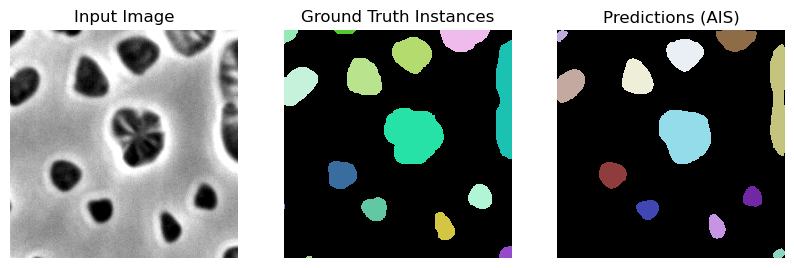

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


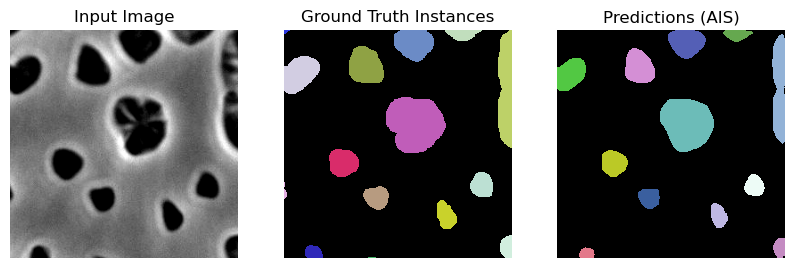

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


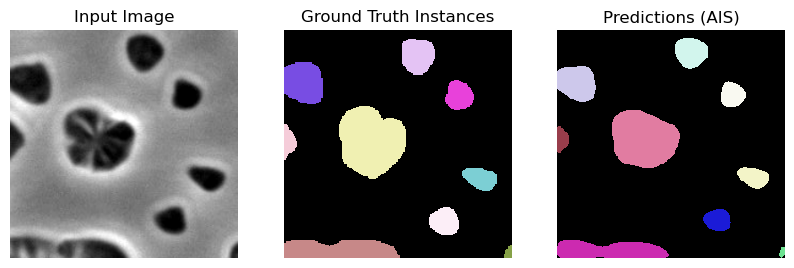

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


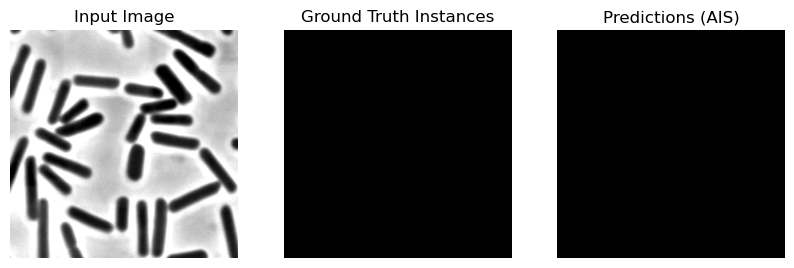

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


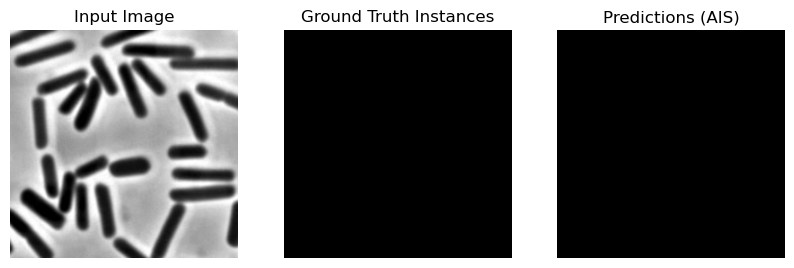

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


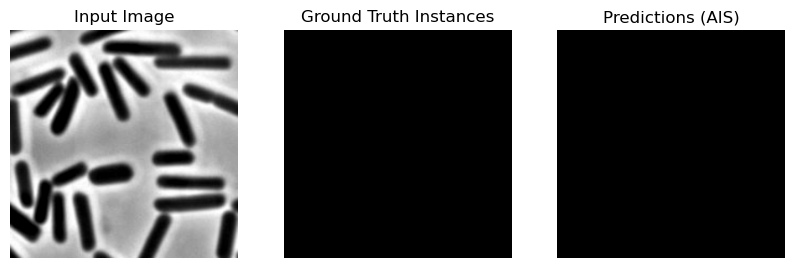

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 14.68it/s]


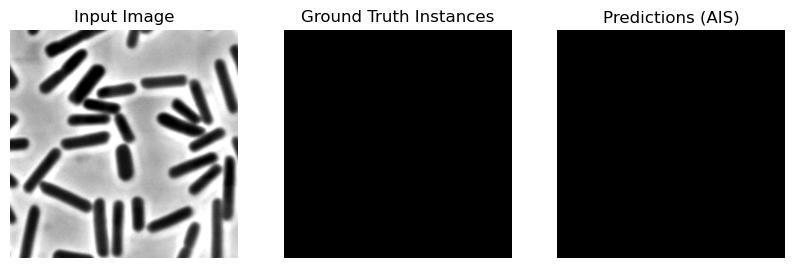

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


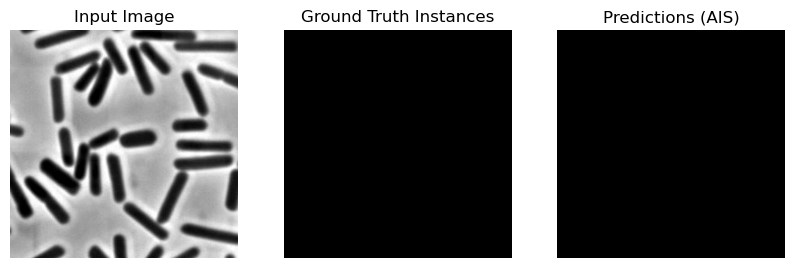

In [ ]:

# Let's check the first 5 images. Feel free to comment out the line below to run inference on all images.
image_paths_ = image_paths[:5]
segmentation_paths_ = segmentation_paths[:5]

# also check images 100-105 which should all be rod images with no instances 
image_paths_ = image_paths_ + image_paths[100:105]
segmentation_paths_ = segmentation_paths_ + segmentation_paths[100:105]

for image_path, segmentation_path in zip(image_paths_, segmentation_paths_):
    image = imageio.imread(image_path)
    segmentation = imageio.imread(segmentation_path)

    # Predicted instances
    prediction = run_automatic_instance_segmentation(
        image=image, checkpoint_path=exported_model_name, model_type=model_type, device=device
    )

    # Visualize the predictions
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input Image")

    ax[1].imshow(segmentation, cmap=random_label_cmap(), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Instances")
    
    ax[2].imshow(prediction, cmap=random_label_cmap(), interpolation="nearest")
    ax[2].axis("off")
    ax[2].set_title("Predictions (AIS)")

    plt.show()
    plt.close()